# Clustering — Assignment Answers (Theory + Code)

This notebook contains:
- **Theoretical answers** (concise, exam-ready)
- **Python code** for all clustering tasks using `scikit-learn`, with visualizations.

> If a cell takes time (especially **t-SNE**), let it run a bit — it's compute heavy by nature.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(42)
plt.rcParams["figure.figsize"] = (7, 5)


## Part A — Theoretical Questions (Clustering)

1. **What is unsupervised learning in ML?**  
   Learning patterns/structure from **unlabeled data**. The model finds clusters, similarities, or latent structure without target labels.

2. **How does K-Means work?**  
   - Choose **k** cluster centers (centroids)  
   - Assign each point to nearest centroid  
   - Update centroids as mean of assigned points  
   - Repeat until assignments stop changing / convergence  
   Objective: minimize **inertia** (within-cluster sum of squares).

3. **Concept of dendrogram in hierarchical clustering**  
   A tree-like diagram showing how clusters **merge (agglomerative)** or **split (divisive)** at different linkage distances. Cutting the tree at a height gives a chosen number of clusters.

4. **Main difference: K-Means vs Hierarchical**  
   - K-Means: needs **k upfront**, iterative centroid optimization, best for spherical clusters.  
   - Hierarchical: builds a **tree of merges/splits**, no need to pick k initially (you cut later), can use various linkage methods.

5. **Advantages of DBSCAN over K-Means**  
   - Finds **non-spherical** clusters  
   - Handles **noise/outliers** explicitly  
   - No need to choose k  
   - Works well when clusters have irregular shapes.

6. **When would you use Silhouette Score?**  
   To evaluate clustering quality when ground-truth labels are absent; useful to compare different k / algorithms by measuring separation vs compactness.

7. **Limitations of Hierarchical Clustering**  
   - Computationally expensive for large datasets (often O(n²) memory/time)  
   - Sensitive to noise/outliers  
   - Early merge/split decisions are hard to undo.

8. **Why is feature scaling important for K-Means?**  
   K-Means uses **Euclidean distances**; features with larger scale dominate distance and distort clusters. Scaling makes each feature contribute fairly.

9. **How does DBSCAN identify noise points?**  
   Points that are **not density-reachable** from any core point (i.e., have fewer than `min_samples` neighbors within `eps`) are labeled **-1** (noise).

10. **Define inertia in K-Means**  
   Sum of squared distances of samples to their assigned centroid:  
   \(\sum_i \lVert x_i - \mu_{c(i)} \rVert^2\). Lower inertia = tighter clusters (but always decreases as k increases).

11. **Elbow method in K-Means**  
   Plot inertia vs k. Choose k at the “elbow” where improvement slows, balancing fit and simplicity.

12. **Concept of density in DBSCAN**  
   Density is based on neighborhood count: a region is dense if many points lie within distance `eps`.

13. **Can hierarchical clustering be used on categorical data?**  
   Yes, but you must use an appropriate **distance metric** (e.g., Hamming, Jaccard, Gower) instead of Euclidean, and sometimes encode categories carefully.

14. **What does a negative Silhouette Score indicate?**  
   A point is likely assigned to the **wrong cluster** (closer to another cluster than its own). Overall negative average suggests poor clustering.

15. **Linkage criteria in hierarchical clustering**  
   Rule for distance between clusters:
   - Single: min pairwise distance  
   - Complete: max pairwise distance  
   - Average: mean pairwise distance  
   - Ward: increase in within-cluster variance.

16. **Why K-Means performs poorly with varying cluster sizes/densities**  
   K-Means assumes similar variance and roughly spherical clusters; big or dense clusters can dominate and pull centroids, misclassifying smaller/sparser clusters.

17. **Core DBSCAN parameters & influence**  
   - `eps`: neighborhood radius (bigger eps → larger/merged clusters, fewer noise points)  
   - `min_samples`: points required to be a **core** point (bigger min_samples → stricter density requirement, more noise).

18. **How K-Means++ improves initialization**  
   Chooses initial centroids **far apart** probabilistically, reducing bad starts, speeding convergence, and improving clustering stability.

19. **What is agglomerative clustering?**  
   Bottom-up hierarchical method: each point starts as its own cluster, and the closest clusters are merged repeatedly until desired cluster count or one cluster remains.

20. **Why Silhouette Score is better than just inertia**  
   Inertia only measures compactness and always improves with higher k. Silhouette measures both **compactness and separation**, helping avoid over-clustering.


In [2]:
def plot_clusters_2d(X, labels, centers=None, title="Clusters"):
    plt.figure()
    labels = np.asarray(labels)
    unique = np.unique(labels)
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            plt.scatter(X[mask, 0], X[mask, 1], marker="x", label="noise")
        else:
            plt.scatter(X[mask, 0], X[mask, 1], label=f"cluster {lab}")
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker="*", s=250, label="centers")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_kmeans_boundaries(X, kmeans, title="K-Means decision boundaries"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=20)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker="*", s=250)
    plt.title(title)
    plt.show()


## Part B — Coding Questions

### 1) make_blobs with 4 centers + K-Means + scatter plot

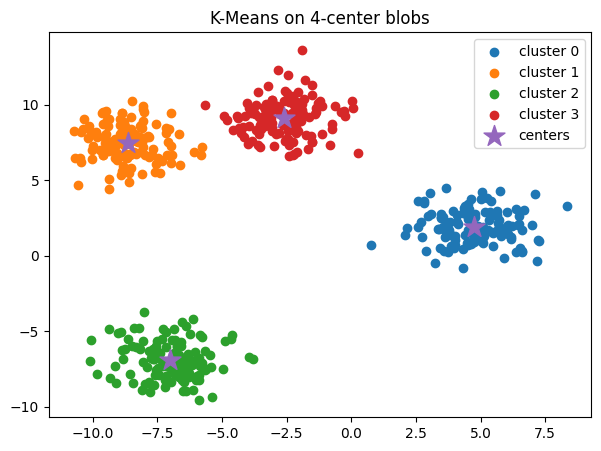

In [3]:
X, y = make_blobs(n_samples=500, centers=4, cluster_std=1.2, random_state=42)
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)
plot_clusters_2d(X, labels, centers=kmeans.cluster_centers_, title="K-Means on 4-center blobs")

### 2) Iris dataset + Agglomerative Clustering (3 clusters) + first 10 labels

In [4]:
iris = load_iris()
X = iris.data
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
pred = agg.fit_predict(X)
pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 3) make_moons + DBSCAN + highlight outliers

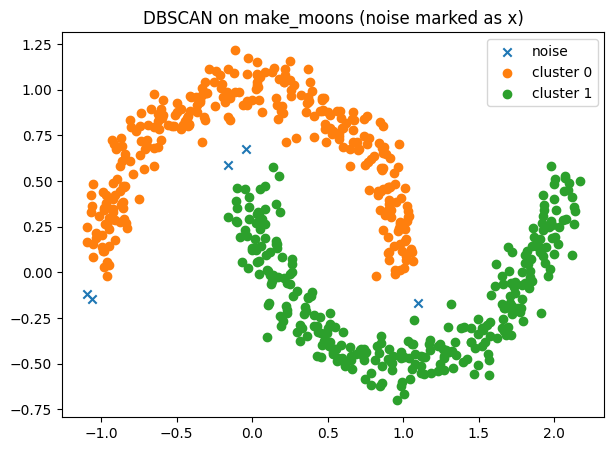

In [5]:
X, _ = make_moons(n_samples=600, noise=0.08, random_state=42)
X_scaled = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.25, min_samples=8)
labels = db.fit_predict(X_scaled)

# plot in original space
plot_clusters_2d(X, labels, title="DBSCAN on make_moons (noise marked as x)")

### 4) Wine dataset + StandardScaler + K-Means + cluster sizes

In [6]:
wine = load_wine()
X = wine.data
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{np.int32(0): np.int64(65),
 np.int32(1): np.int64(51),
 np.int32(2): np.int64(62)}

### 5) make_circles + DBSCAN + plot

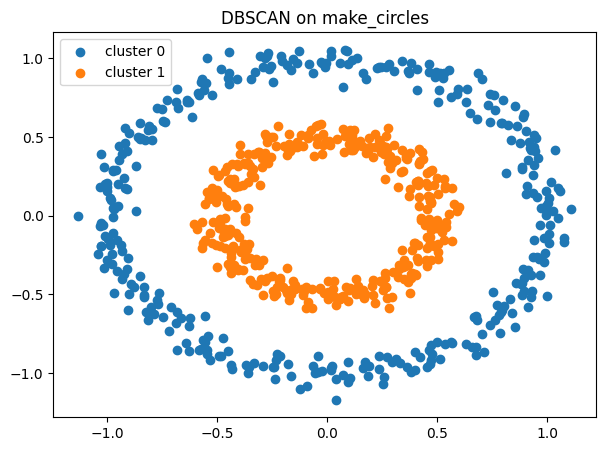

In [7]:
X, _ = make_circles(n_samples=700, factor=0.5, noise=0.05, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.25, min_samples=10)
labels = db.fit_predict(X_scaled)
plot_clusters_2d(X, labels, title="DBSCAN on make_circles")

### 6) Breast Cancer + MinMaxScaler + K-Means (k=2) + centroids

In [8]:
bc = load_breast_cancer()
X = bc.data
X_scaled = MinMaxScaler().fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
kmeans.fit(X_scaled)

centroids = kmeans.cluster_centers_
centroids

array([[0.50483563, 0.39560329, 0.50578661, 0.36376576, 0.46988732,
        0.42226302, 0.41838662, 0.46928035, 0.45899738, 0.29945886,
        0.19093085, 0.19112073, 0.17903433, 0.13086432, 0.18017962,
        0.25890126, 0.12542475, 0.30942779, 0.190072  , 0.13266975,
        0.48047448, 0.45107371, 0.4655302 , 0.31460597, 0.49868817,
        0.36391461, 0.39027292, 0.65827197, 0.33752296, 0.26041387],
       [0.25535358, 0.28833455, 0.24696416, 0.14388369, 0.35743076,
        0.18019471, 0.10344776, 0.1306603 , 0.34011829, 0.25591606,
        0.06427485, 0.18843043, 0.05975663, 0.02870108, 0.18158628,
        0.13242941, 0.05821528, 0.18069336, 0.17221057, 0.08403996,
        0.2052406 , 0.32069002, 0.19242138, 0.09943446, 0.3571115 ,
        0.14873935, 0.13142287, 0.26231363, 0.22639412, 0.15437354]])

### 7) make_blobs with varying std dev + DBSCAN

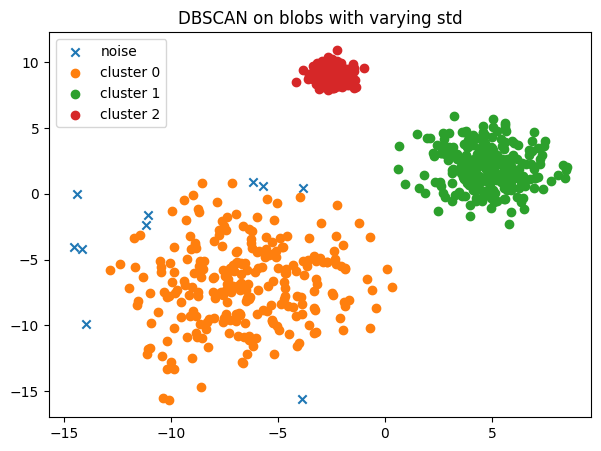

In [9]:
X, _ = make_blobs(n_samples=800, centers=3, cluster_std=[0.5, 1.5, 3.0], random_state=42)
X_scaled = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.35, min_samples=10)
labels = db.fit_predict(X_scaled)
plot_clusters_2d(X, labels, title="DBSCAN on blobs with varying std")

### 8) Digits + PCA to 2D + K-Means visualize

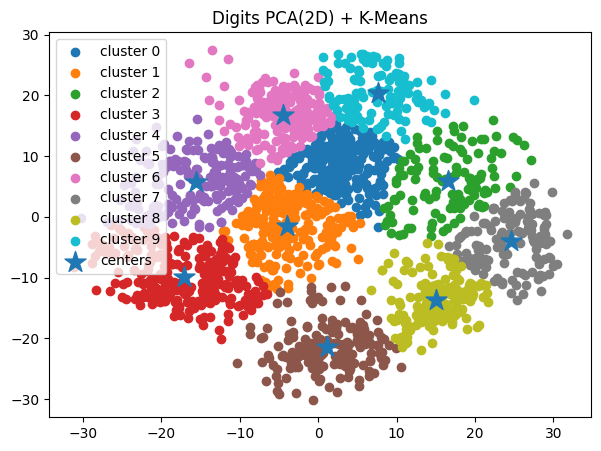

In [10]:
digits = load_digits()
X = digits.data
X_pca = PCA(n_components=2, random_state=42).fit_transform(X)

kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_pca)
plot_clusters_2d(X_pca, labels, centers=kmeans.cluster_centers_, title="Digits PCA(2D) + K-Means")

### 9) make_blobs + Silhouette score for k=2..5 (bar chart)

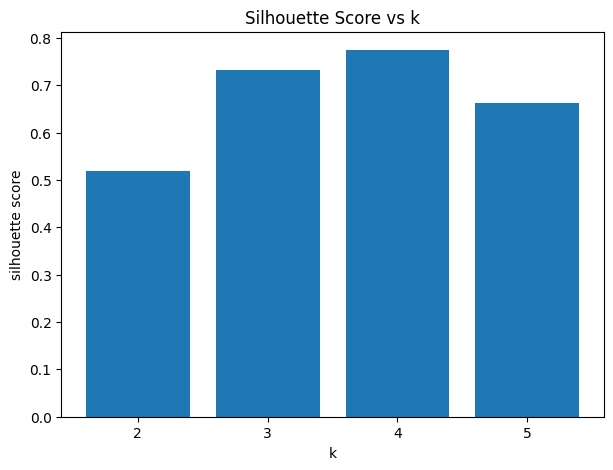

{2: 0.519762314792493,
 3: 0.7312090177576122,
 4: 0.7740768434629797,
 5: 0.6623472124748632}

In [11]:
X, _ = make_blobs(n_samples=600, centers=4, cluster_std=1.1, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

ks = [2, 3, 4, 5]
scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.bar([str(k) for k in ks], scores)
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.show()

dict(zip(ks, scores))

### 10) Iris + dendrogram (average linkage)

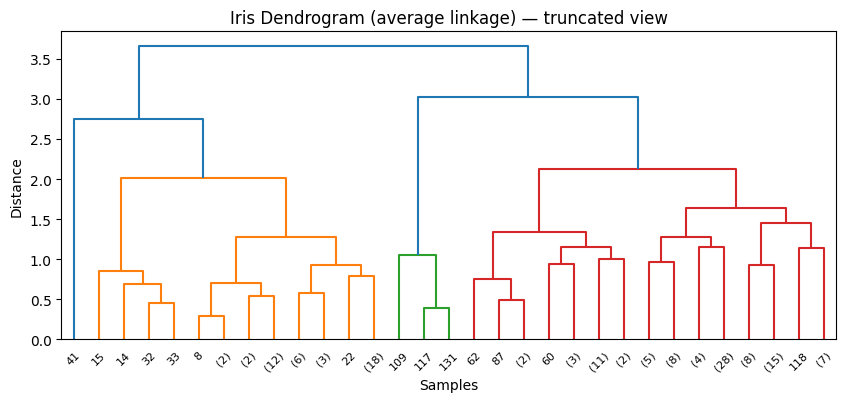

In [12]:
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)

Z = linkage(X, method="average")
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Iris Dendrogram (average linkage) — truncated view")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

### 11) Overlapping blobs + K-Means + decision boundaries

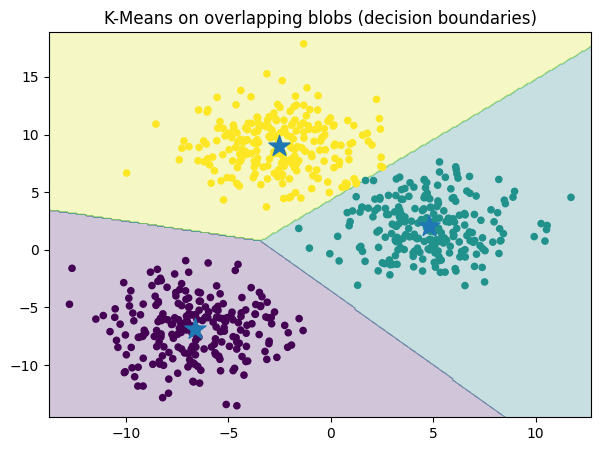

In [13]:
X, _ = make_blobs(n_samples=700, centers=3, cluster_std=2.3, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X)
plot_kmeans_boundaries(X, kmeans, title="K-Means on overlapping blobs (decision boundaries)")

### 12) Digits + t-SNE (2D) + DBSCAN visualize (can be slow)

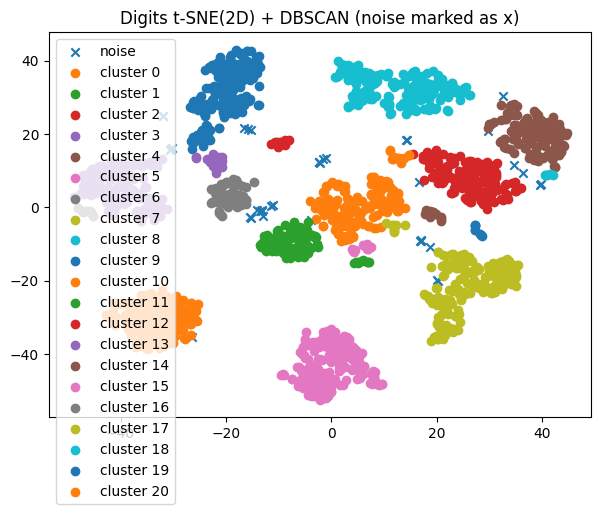

In [14]:
digits = load_digits()
X = digits.data
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

db = DBSCAN(eps=2.5, min_samples=8)
labels = db.fit_predict(X_tsne)

plot_clusters_2d(X_tsne, labels, title="Digits t-SNE(2D) + DBSCAN (noise marked as x)")

### 13) make_blobs + Agglomerative (complete linkage) + plot

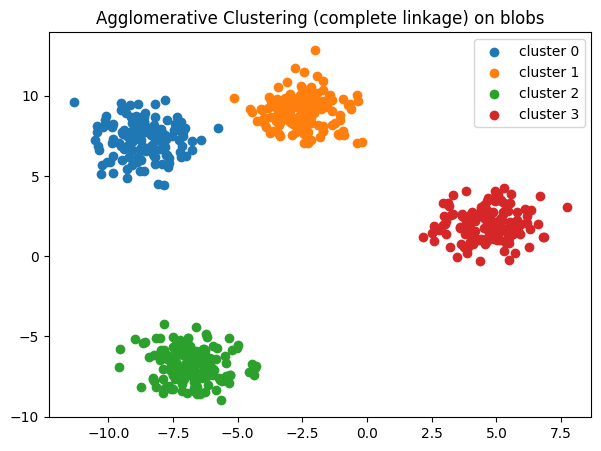

In [15]:
X, _ = make_blobs(n_samples=600, centers=4, cluster_std=1.0, random_state=42)
agg = AgglomerativeClustering(n_clusters=4, linkage="complete")
labels = agg.fit_predict(X)
plot_clusters_2d(X, labels, title="Agglomerative Clustering (complete linkage) on blobs")

### 14) Breast Cancer + inertia for K=2..6 (line plot)

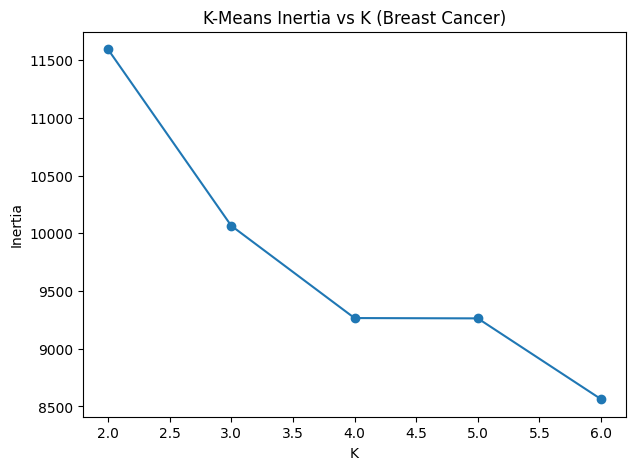

[(2, 11595.683312822139),
 (3, 10066.281842533348),
 (4, 9266.15423578978),
 (5, 9263.404816345357),
 (6, 8562.878816973254)]

In [16]:
bc = load_breast_cancer()
X = StandardScaler().fit_transform(bc.data)

ks = range(2, 7)
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.title("K-Means Inertia vs K (Breast Cancer)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

list(zip(ks, inertias))

### 15) make_circles + Agglomerative (single linkage)

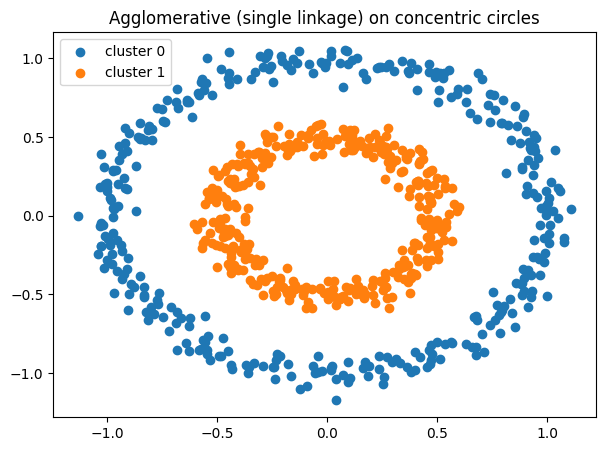

In [17]:
X, _ = make_circles(n_samples=700, factor=0.5, noise=0.05, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

agg = AgglomerativeClustering(n_clusters=2, linkage="single")
labels = agg.fit_predict(X_scaled)
plot_clusters_2d(X, labels, title="Agglomerative (single linkage) on concentric circles")

### 16) Wine + DBSCAN after scaling + number of clusters (excluding noise)

In [18]:
wine = load_wine()
X = StandardScaler().fit_transform(wine.data)

db = DBSCAN(eps=1.3, min_samples=7)
labels = db.fit_predict(X)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

n_clusters, n_noise

(0, np.int64(178))

### 17) make_blobs + K-Means + plot cluster centers

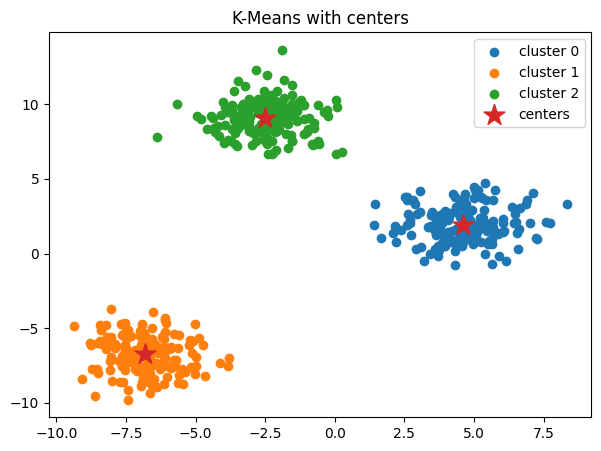

In [19]:
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=1.2, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)
plot_clusters_2d(X, labels, centers=kmeans.cluster_centers_, title="K-Means with centers")

### 18) Iris + DBSCAN + count noise samples

In [20]:
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)

db = DBSCAN(eps=0.8, min_samples=5)
labels = db.fit_predict(X)

noise_count = int(np.sum(labels == -1))
noise_count

4

### 19) make_moons (non-linear) + K-Means visualize

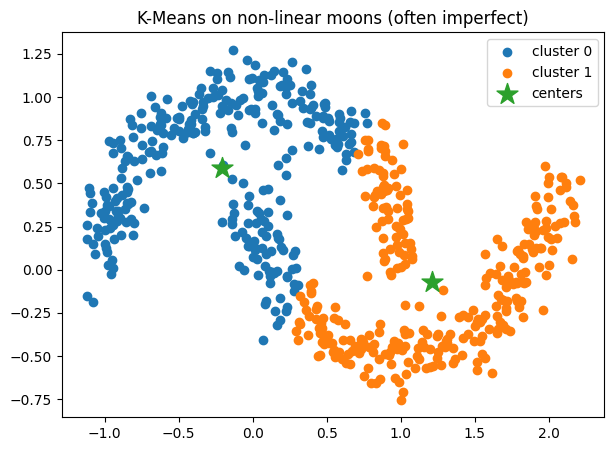

In [21]:
X, _ = make_moons(n_samples=600, noise=0.1, random_state=42)
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)
plot_clusters_2d(X, labels, centers=kmeans.cluster_centers_, title="K-Means on non-linear moons (often imperfect)")

### 20) Digits + PCA(3D) + K-Means + 3D scatter

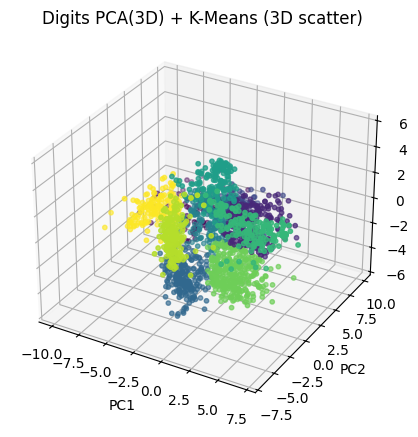

In [22]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

digits = load_digits()
X = StandardScaler().fit_transform(digits.data)
X_pca3 = PCA(n_components=3, random_state=42).fit_transform(X)

kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_pca3)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=labels, s=10)
ax.set_title("Digits PCA(3D) + K-Means (3D scatter)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.show()

21) make_blobs (5 centers) + KMeans + silhouette_score

In [23]:
X, _ = make_blobs(n_samples=700, centers=5, cluster_std=1.1, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)

score = silhouette_score(X_scaled, labels)
score

0.645367101364615

22) Breast Cancer + PCA(2D) + Agglomerative + visualize

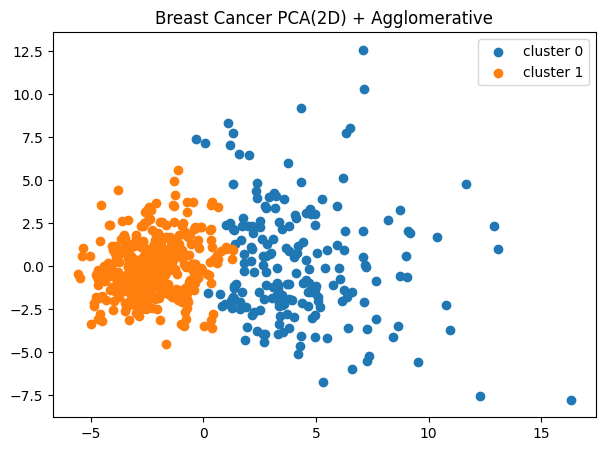

In [24]:
bc = load_breast_cancer()
X = StandardScaler().fit_transform(bc.data)
X_2d = PCA(n_components=2, random_state=42).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels = agg.fit_predict(X_2d)
plot_clusters_2d(X_2d, labels, title="Breast Cancer PCA(2D) + Agglomerative")

23) Noisy circles: compare KMeans vs DBSCAN (side-by-side)

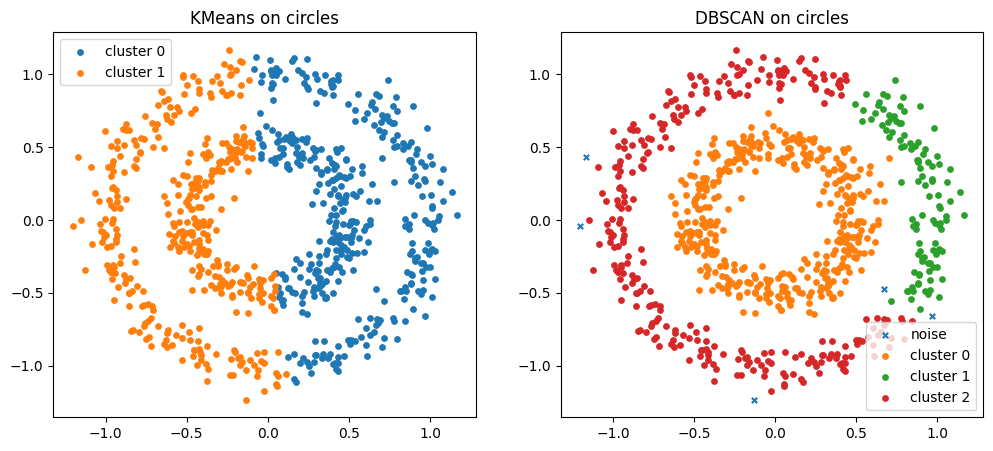

In [25]:
X, _ = make_circles(n_samples=800, factor=0.5, noise=0.08, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=2, random_state=42, n_init="auto")
km_labels = km.fit_predict(X_scaled)

db = DBSCAN(eps=0.25, min_samples=10)
db_labels = db.fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KMeans plot
for lab in np.unique(km_labels):
    m = km_labels == lab
    axes[0].scatter(X[m, 0], X[m, 1], s=15, label=f"cluster {lab}")
axes[0].set_title("KMeans on circles")
axes[0].legend()

# DBSCAN plot
for lab in np.unique(db_labels):
    m = db_labels == lab
    if lab == -1:
        axes[1].scatter(X[m, 0], X[m, 1], s=15, marker="x", label="noise")
    else:
        axes[1].scatter(X[m, 0], X[m, 1], s=15, label=f"cluster {lab}")
axes[1].set_title("DBSCAN on circles")
axes[1].legend()

plt.show()

24) Iris: Silhouette Coefficient for each sample after KMeans

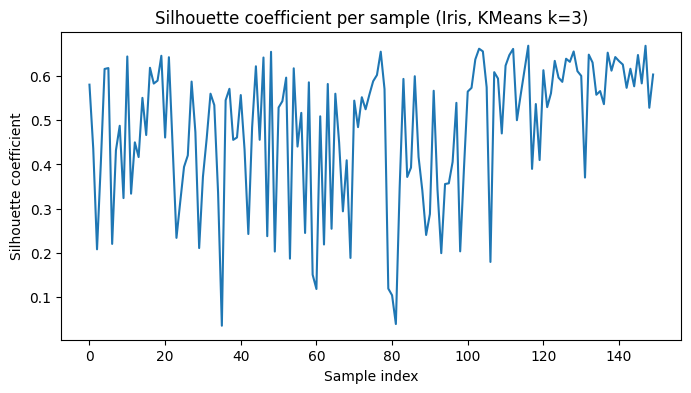

(array([0.58004708, 0.43584112, 0.20837912, 0.40135623, 0.61548528,
        0.6175133 , 0.22053873, 0.43186887, 0.4872296 , 0.32398734]),
 np.float64(0.4798814508199817))

In [26]:
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)

km = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = km.fit_predict(X)

sample_scores = silhouette_samples(X, labels)

plt.figure(figsize=(8, 4))
plt.plot(sample_scores)
plt.title("Silhouette coefficient per sample (Iris, KMeans k=3)")
plt.xlabel("Sample index")
plt.ylabel("Silhouette coefficient")
plt.show()

(sample_scores[:10], sample_scores.mean())

25) make_blobs + Agglomerative ('average' linkage) + visualize

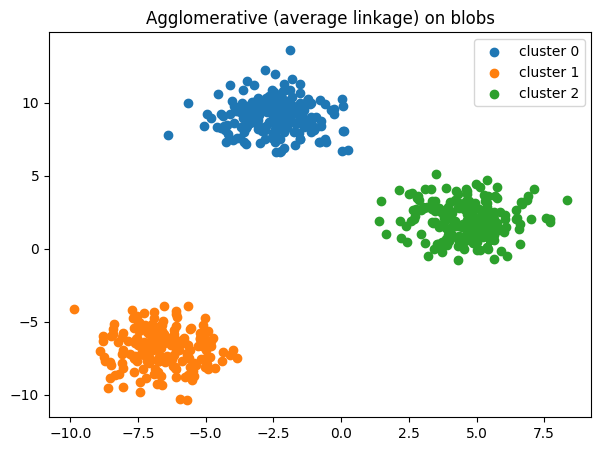

In [27]:
X, _ = make_blobs(n_samples=600, centers=3, cluster_std=1.2, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

agg = AgglomerativeClustering(n_clusters=3, linkage="average")
labels = agg.fit_predict(X_scaled)
plot_clusters_2d(X, labels, title="Agglomerative (average linkage) on blobs")

26) Wine + KMeans + pairplot-like visualization (first 4 features)
> Note: The prompt mentions seaborn pairplot. Here we use `pandas.plotting.scatter_matrix` (similar output) to keep dependencies minimal.

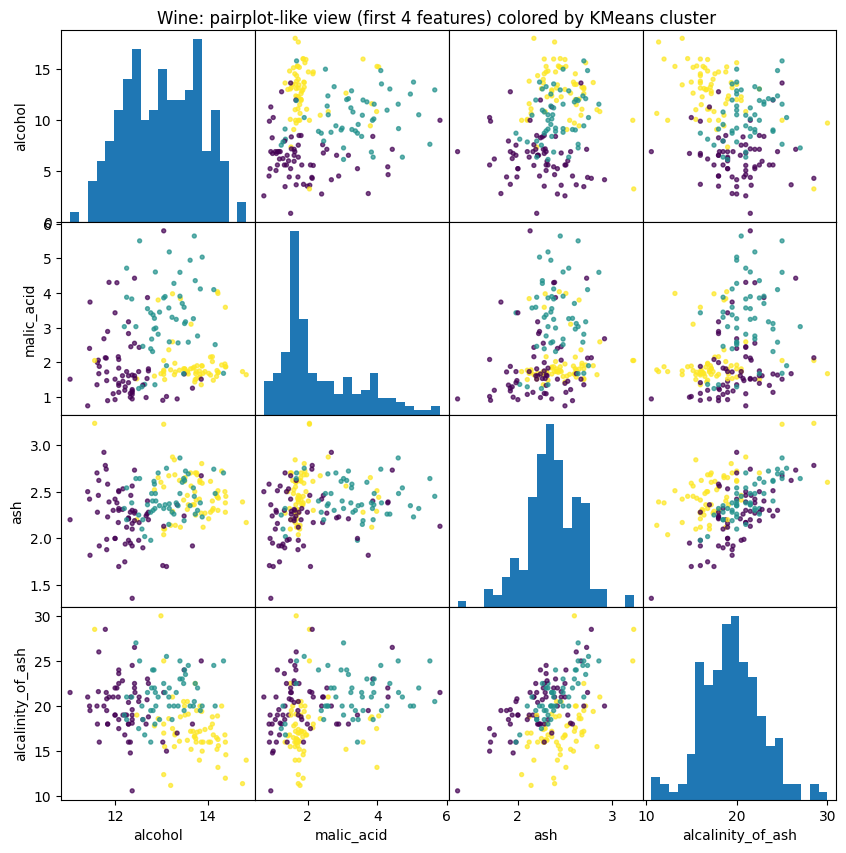

In [28]:
from pandas.plotting import scatter_matrix

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
X_scaled = StandardScaler().fit_transform(df.values)

km = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = km.fit_predict(X_scaled)
df_plot = df.iloc[:, :4].copy()
df_plot["cluster"] = labels

# scatter matrix colored by cluster
axes = scatter_matrix(df_plot.iloc[:, :4], figsize=(10, 10), diagonal="kde", alpha=0.6)
# Color points by cluster manually (simple overlay)
for ax in np.ravel(axes):
    ax.cla()
for i, col_i in enumerate(df_plot.columns[:4]):
    for j, col_j in enumerate(df_plot.columns[:4]):
        ax = axes[i, j]
        if i == j:
            ax.hist(df_plot[col_i], bins=20)
        else:
            ax.scatter(df_plot[col_j], df_plot[col_i], c=df_plot["cluster"], s=8, alpha=0.7)
        ax.set_xlabel(col_j)
        ax.set_ylabel(col_i)
plt.suptitle("Wine: pairplot-like view (first 4 features) colored by KMeans cluster", y=0.9)
plt.show()

27) Noisy blobs + DBSCAN: count clusters and noise points

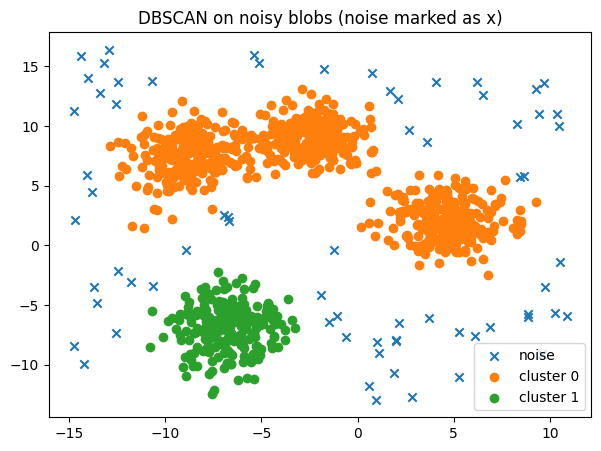

{'clusters': 2, 'noise_points': 69}

In [29]:
X, _ = make_blobs(n_samples=900, centers=4, cluster_std=1.5, random_state=42)
# add extra random noise points
noise = np.random.uniform(low=X.min(axis=0)-2, high=X.max(axis=0)+2, size=(120, 2))
X2 = np.vstack([X, noise])

X_scaled = StandardScaler().fit_transform(X2)

db = DBSCAN(eps=0.3, min_samples=10)
labels = db.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int(np.sum(labels == -1))

plot_clusters_2d(X2, labels, title="DBSCAN on noisy blobs (noise marked as x)")
{"clusters": n_clusters, "noise_points": n_noise}

28) Digits + t-SNE + Agglomerative Clustering + plot (can be slow)

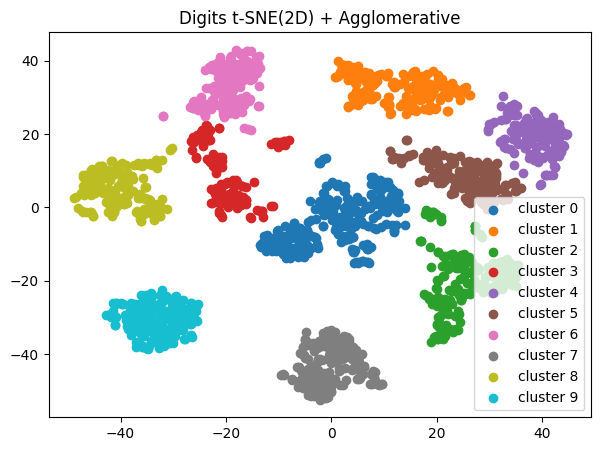

In [30]:
digits = load_digits()
X = StandardScaler().fit_transform(digits.data)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X)

agg = AgglomerativeClustering(n_clusters=10, linkage="ward")
labels = agg.fit_predict(X_tsne)

plot_clusters_2d(X_tsne, labels, title="Digits t-SNE(2D) + Agglomerative")